In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.init as weight_init

import numpy as np
import numpy.ma as ma
import pickle
import time
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cm as cmx

from abc import ABCMeta, abstractmethod
from __future__ import division

# abstract class python 2 & 3 compatible
ABC = ABCMeta('ABC', (object,), {})

import os
current_dir = os.path.dirname(os.path.realpath('__file__'))
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



import os, sys
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\PsychRNN")

from psychrnn.backend.rnn import RNN
from psychrnn.tasks.task import Task

from utils import *

In [2]:
#training parameters
data_size_per_coherence = 5000
coherences = [0.7, 0.5, 0.3, 0.1, 0.05, 0.025]
#maybe 0.025 is too low of a difference
#stimulus is on for np.random.random() * self.T / 4.0 + self.T / 8.0
#meaning that the expected duration is self.T*3/8
#so for 200 timepoints the expected difference is 0.025*200*3/8=1.875
#but this should be sufficient

train_params = {}
#dataset
train_params['data_size_per_coherence'] = data_size_per_coherence
train_params['coherences'] = coherences
train_params['total_data_size'] = 10000
train_params['train_proportion'] = 0.8
train_params['dt'] = 10
train_params['tau'] = 100
train_params['T'] = 2000

#saving and printing
train_params['save_weights_path'] =  None # Where to save the model after training. Default: None
train_params['save_training_weights_epoch'] = 1 # save training weights every 'save_training_weights_epoch' epochs. Default: 1
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True

#
train_params['dataloader_batch_size'] = 50
train_params['learning_rate'] = 1e-3 # Sets learning rate if use default optimizer Default: 1e-3
train_params['loss_epoch'] = 1 # Compute and record loss every 'loss_epoch' epochs. 
train_params['loss_function'] = "ce" # Loss function. Default: cross entropy
train_params['optimizer'] = "rmsprop" # Optimizer. default: RMSProp
train_params['sgd_momentum'] = 0.95
train_params['scheduler'] = None #"steplr", "cosineannealing"
train_params['steplr_gamma'] = 0.1 #multiply learning rate by this facter every train_params['scheduler_step_size'] epochs
train_params['scheduler_step_size'] = 40
train_params['check_the_dead'] = True
train_params['weight_reinitialization_variance'] = True

#early stopping params
train_params['early_stopping_criterion_epochs'] = 9 #if loss doesn't decrease for early_stopping_criterion_epochs, stop training
train_params['difference_tolerance'] = 1e-5

#curriculum params
train_params['curriculum_switching_criterion_epochs'] = 4 #loss to achieve before whiching to harder curriculum
train_params['curriculum_learning'] = True
train_params['accuracy_goal'] = 0.99
train_params['max_epochs_per_curriculum'] = 100
train_params['min_epochs_per_curriculum'] = 5

train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True

#dataset
train_params['dataset'] = "C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\curriculum_dataset_low0.pickle"
train_params['dataset_idx'] = ""

In [3]:
###one dataset
# train_set, test_set = make_train_test_sets(total_data_size, train_proportion)
# train_x, train_y, train_output_mask, train_trial_params = train_set
# dataset = TensorDataset(torch.tensor(train_x, dtype=torch.float), torch.tensor(train_y, dtype=torch.float))
# data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

###curriculum dataset
if train_params['dataset'] != None:
    with open(train_params['dataset'], 'rb') as handle:
        curriculum_dataset = pickle.load(handle)
else:
    if train_params['curriculum_learning']:
        curriculum_dataset, data_params = make_curriculum_datasets(data_size_per_coherence, coherences,
                                                                   dt=train_params['dt'], tau=train_params['tau'], T=train_params['T'])
        # with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\curriculum_dataset_low0.pickle", 'wb') as handle:
        #     pickle.dump(curriculum_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [4]:
# set model parameters
network_params = {}
network_params['N_in'] = 2
network_params['N_out'] = 2
network_params['N_rec'] = 20
network_params['transform_function'] = 'relu'
network_params['n_layers'] = 1
network_params['hidden_initial_activations'] = 'random'
network_params['hidden_initial_variance'] = 0.001

#set training parameters
train_params['loss_function'] = "ce"
train_params['optimizer'] = "sgd"
train_params['scheduler'] = "steplr" #"cosineannealing" #None# ""  ### None

#initialize model
rnn_model = RNNModel(network_params['N_in'], network_params['N_out'], network_params['N_rec'],
                     n_layers=network_params['n_layers'], transform_function=network_params['transform_function']).to(device)

#initialize optimizer
if train_params['optimizer'] == "sgd":
    optimizer = optim.SGD(rnn_model.parameters(), lr=train_params['learning_rate'], momentum=train_params['sgd_momentum'])
elif train_params['optimizer'] == "rmsprop":
    optimizer = optim.RMSprop(rnn_model.parameters(), lr=train_params['learning_rate'])
elif train_params['optimizer'] == "adam":
    optimizer = optim.Adam(rnn_model.parameters(), lr=train_params['learning_rate'])

#initialize loss function
if train_params['loss_function'] == "mse":
    loss_fn = nn.MSELoss().to(device)
if train_params['loss_function'] == "ce":
    loss_fn = nn.CrossEntropyLoss().to(device)

#initialize learning rate scheduler
if train_params['scheduler'] == "steplr":
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=train_params['scheduler_step_size'], gamma=train_params['steplr_gamma'])
if train_params['scheduler'] == "cosineannealing":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_params['max_epochs_per_curriculum'])
if train_params['scheduler'] == None:
    scheduler = None

time_idx = int(time.time())
network_params['idx'] = time_idx
exp_path = current_dir + '/experiments/'+train_params['optimizer']+'_'+train_params['loss_function']+'_exp_%s/'%time_idx
train_params['save_weights_path'] = exp_path
train_params['figures_path'] = exp_path + '/figures/'
makedirs(train_params['figures_path'])
training_path = exp_path + '/training/' #to save weights during training
train_params['training_weights_path'] = training_path
makedirs(training_path)

#save parameters, network and training
with open(exp_path + '/network_params.pickle', 'wb') as handle:
    pickle.dump(network_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(exp_path + '/train_params.pickle', 'wb') as handle:
    pickle.dump(train_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
rnn_model, losses, curriculum_stop_info = curriculum_learning(model=rnn_model,
                                                              curriculum_dataset=curriculum_dataset,
                                                              train_params=train_params,
                                                              network_params=network_params,
                                                              loss_fn=loss_fn,
                                                              optimizer=optimizer,
                                                              scheduler=scheduler
                                                             )

Epoch     0 loss: 0.3374, validation loss: 0.3423, min val loss: inf, accuracy: 0.505, trigger time:  0
Epoch     1 loss: 0.3373, validation loss: 0.3423, min val loss: 0.3423, accuracy: 0.505, trigger time:  0
Epoch     2 loss: 0.3373, validation loss: 0.3423, min val loss: 0.3423, accuracy: 0.505, trigger time:  0
Epoch     3 loss: 0.3373, validation loss: 0.3423, min val loss: 0.3423, accuracy: 0.505, trigger time:  1
Epoch     4 loss: 0.3373, validation loss: 0.3423, min val loss: 0.3423, accuracy: 0.505, trigger time:  2
Epoch     5 loss: 0.3373, validation loss: 0.3423, min val loss: 0.3423, accuracy: 0.505, trigger time:  3
Epoch     6 loss: 0.3373, validation loss: 0.3423, min val loss: 0.3423, accuracy: 0.505, trigger time:  4
Epoch     7 loss: 0.3373, validation loss: 0.3423, min val loss: 0.3423, accuracy: 0.505, trigger time:  5
Epoch     8 loss: 0.3373, validation loss: 0.3423, min val loss: 0.3423, accuracy: 0.505, trigger time:  6
Epoch     9 loss: 0.3373, validation los

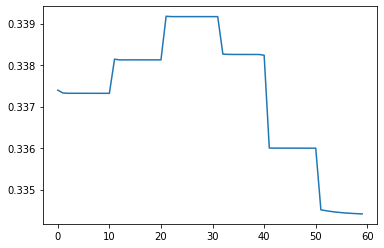

In [6]:
plt.plot(losses)
# plt.ylim([0,1])
# plt.savefig(train_params['figures_path'] + '/losses.pdf')

In [16]:
#test 
pd = PerceptualDiscrimination(dt=train_params['dt'], tau=train_params['tau'], T=train_params['T'],
                              N_batch=train_params['total_data_size'], coherence_list = train_params['coherences'])
x, y, output_mask, _ = pd.get_trial_batch() #generate self.N_batch trials
inputs = torch.tensor(x, dtype=torch.float)
yhat, hidden = rnn_model(inputs)

print("Accuracy:", pd.accuracy_function(y, yhat.detach().numpy(), output_mask))

Accuracy: 0.4965


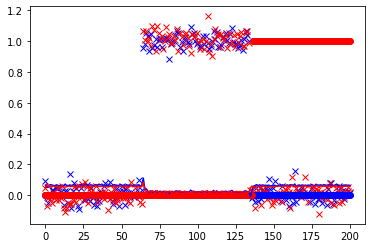

In [8]:
yhat_np = yhat.detach().numpy()
# plt.plot(yhat_np[0,:,0], yhat_np[0,:,1])
times = np.linspace(0, 200, yhat_np.shape[1])
plt.plot(times, x[0,:,0], 'bx', times, x[0,:,1], 'rx')
plt.plot(times, y[0,:,0], 'bo', times, y[0,:,1], 'ro')
plt.plot(times, yhat_np[0,:,0], 'b-', times, yhat_np[0,:,1], 'r-')

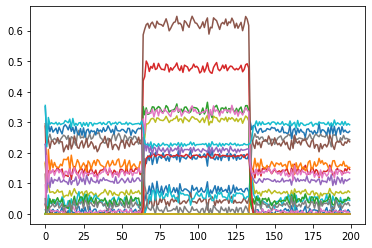

In [9]:
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim)
out, hidden = rnn_model.rnn(inputs, hidden)

plt.plot(out[0,:,:].detach().numpy());

In [10]:
T = 10**3
input_size = train_params['dataloader_batch_size']
x = np.linspace(np.zeros((int(T),2)), np.ones((int(T),2)), num=input_size, axis=0)
x[:,:,0] = 0.
inputs = torch.tensor(x, dtype=torch.float)
yhat, hidden = rnn_model(inputs)

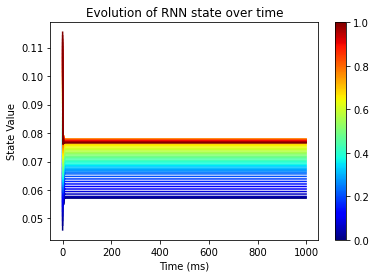

In [11]:
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
values = np.linspace(0,1,input_size)

unit_idx = 1
yhat_np = yhat.detach().numpy()
for i in range(input_size):
    plt.plot(range(0, len(yhat_np[i,:,unit_idx].T),1),yhat_np[i,:,unit_idx].T, color=scalarMap.to_rgba(values[i]))
plt.ylabel("State Value")
plt.xlabel("Time (ms)")
s_m = matplotlib.cm.ScalarMappable(cmap=jet, norm=cNorm)
plt.colorbar(s_m)
# plt.ylim([-1,2])
plt.title("Evolution of RNN state over time");

plt.savefig(train_params['figures_path'] + "\\x0_constantinput_internaldyns_%s.pdf"%time_idx)

In [15]:
x.pd = PerceptualDiscrimination(dt=train_params['dt'], tau=train_params['tau'], T=train_params['T'],
                              N_batch=train_params['total_data_size'], coherence_list = train_params['coherences'])
x, y, output_mask, _ = pd.get_trial_batch() #generate self.N_batch trials
inputs = torch.tensor(x, dtype=torch.float)
yhat, hidden = rnn_model(inputs)

(50, 1000, 2)

In [17]:
model = rnn_model
with torch.no_grad():
    hidden = torch.zeros(model.n_layers, x.shape[0], model.hidden_dim) 
    hidden_states, hidden_last = model.rnn(inputs, hidden)
    hidden_states = hidden_states.detach().numpy()
    dead_neurons = np.where(np.sum(hidden_states, axis=(0,1))==0)

In [18]:
dead_neurons

(array([ 2,  4, 18], dtype=int64),)

In [27]:
for coherence in curriculum_dataset.keys():
    # print(curriculum_dataset[coherence])
    data_list = curriculum_dataset[str(coherence)][0]
    train_x, train_y, train_output_mask, train_trial_params = data_list
    print(coherence)
    inputs = torch.tensor(train_x, dtype=torch.float)
    hidden = torch.zeros(model.n_layers, train_x.shape[0], model.hidden_dim) 
    hidden_states, hidden_last = model.rnn(inputs, hidden)
    hidden_states = hidden_states.detach().numpy()
    dead_neurons = np.where(np.sum(hidden_states, axis=(0,1))==0)
    print(dead_neurons)

0.7
(array([ 2,  4, 18], dtype=int64),)
0.5
(array([ 1,  2,  4, 18], dtype=int64),)
0.3
(array([ 1,  2,  4, 18], dtype=int64),)
0.1
(array([ 1,  2,  4, 18], dtype=int64),)
0.05
(array([ 1,  2,  4, 18], dtype=int64),)
0.025
(array([ 1,  2,  4, 18], dtype=int64),)
